In [3]:
import requests
import csv 
import pandas as pd
import numpy as np
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from arch import arch_model
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [4]:
pip install yfinance


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
def getStockData(stockSymbol):
    CSV_URL = "https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol="+stockSymbol+"&interval=1min&slice=year1month1&apikey=UHXXK2NEVHOR2LSL"

    with requests.Session() as s:
        download = s.get(CSV_URL)

        print(download.status_code)

        decoded_content = download.content.decode('utf-8')

        cr = csv.reader(decoded_content.splitlines(), delimiter=',')
        my_list = list(cr)

        df = pd.DataFrame(my_list)
        return df


In [22]:
df = getStockData("AAPL")
df.columns = df.iloc[0]
df.head()

200


,time,open,high,low,close,volume
0,time,open,high,low,close,volume
1,2023-03-13 20:00:00,150.9,150.9,150.84,150.9,2520
2,2023-03-13 19:59:00,150.78,150.78,150.78,150.78,327
3,2023-03-13 19:58:00,150.77,150.83,150.77,150.77,1346
4,2023-03-13 19:56:00,150.77,150.77,150.77,150.77,246


Iteration:      1,   Func. Count:     33,   Neg. LLF: 144.97721325164395
Iteration:      2,   Func. Count:     70,   Neg. LLF: 1275.7659079843118
Iteration:      3,   Func. Count:    103,   Neg. LLF: 245.55022531625076
Iteration:      4,   Func. Count:    136,   Neg. LLF: 187.26859451751002
Iteration:      5,   Func. Count:    169,   Neg. LLF: 724.1400316135808
Iteration:      6,   Func. Count:    202,   Neg. LLF: 100.27727827691136
Iteration:      7,   Func. Count:    235,   Neg. LLF: 60.60064103257554
Iteration:      8,   Func. Count:    268,   Neg. LLF: 72.69297658735009
Iteration:      9,   Func. Count:    301,   Neg. LLF: 59.6362181944505
Iteration:     10,   Func. Count:    334,   Neg. LLF: 79.04219757706335
Iteration:     11,   Func. Count:    367,   Neg. LLF: 51.21701263491846
Iteration:     12,   Func. Count:    400,   Neg. LLF: 61.17005664562808
Iteration:     13,   Func. Count:    433,   Neg. LLF: 50.886368314126614
Iteration:     14,   Func. Count:    466,   Neg. LLF: 50.27

c:\Users\nawal\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


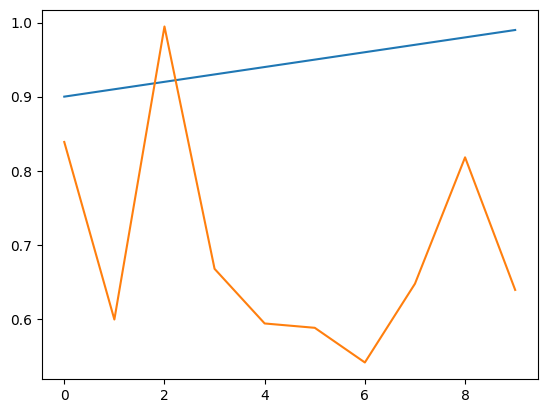

In [7]:
from random import gauss

# create dataset
data = [gauss(0, i*0.01) for i in range(0,100)]
# split into train/test
n_test = 10
train, test = data[:-n_test], data[-n_test:]
# define model
model = arch_model(train, mean='Zero', vol='GARCH', p=15, q=15)
# fit model
model_fit = model.fit()
# forecast the test set
yhat = model_fit.forecast(horizon=n_test)
# plot the actual variance
var = [i*0.01 for i in range(0,100)]
plt.plot(var[-n_test:])
# plot forecast variance
plt.plot(yhat.variance.values[-1, :])
plt.show()

c:\Users\nawal\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.782e-07. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\nawal\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\nawal\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to si

Iteration:      1,   Func. Count:      5,   Neg. LLF: -73369.82919686701
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -73369.82915590369
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


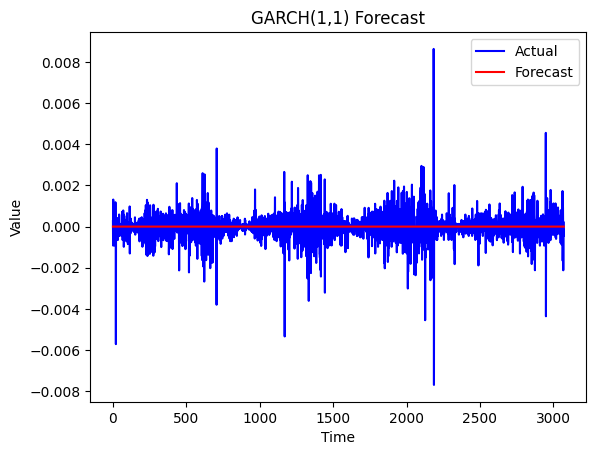

In [8]:
df['close'] = pd.to_numeric(df['close'], errors='coerce')
df.dropna(inplace=True)

log_returns = np.log(df['close'] / df['close'].shift(-1))

# split the data into train and test
train = log_returns[:int(0.8*(len(log_returns)))]
test = log_returns[int(0.8*(len(log_returns))):]


# define the model
model = arch_model(train, mean='Constant', vol='GARCH', p=1, q=1)

# fit the model
model_fit = model.fit()

# forecast the test set
yhat = model_fit.forecast(horizon=len(test))

# plot the actual and forecast values
plt.plot(test.values, label='Actual', color='blue')
plt.plot(yhat.variance.values[-1, :], label='Forecast', color='red')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('GARCH(1,1) Forecast')
plt.legend()
plt.show()

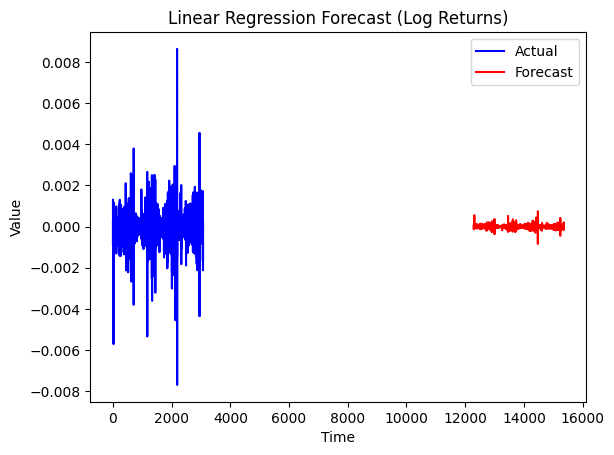

In [9]:
import statsmodels.api as sm

df['close'] = pd.to_numeric(df['close'], errors='coerce')
df.dropna(inplace=True)

# calculate log returns
df['log_returns'] = np.log(df['close'] / df['close'].shift(-1))

# create lagged variables
df['lagged_returns_1'] = df['log_returns'].shift(-1)
# df['lagged_returns_2'] = df['log_returns'].shift(-2)

# split the data into train and test
train = df[['log_returns', 'lagged_returns_1']][:int(0.8*(len(df)))]
test = df[['log_returns', 'lagged_returns_1']][int(0.8*(len(df))):]

# define the model
model = sm.OLS(train['log_returns'], train[['lagged_returns_1']].assign(constant=1))

# fit the model
model_fit = model.fit()

# forecast the test set
yhat = model_fit.predict(test[['lagged_returns_1']].assign(constant=1))

# plot the actual and forecast values
plt.plot(test['log_returns'].values, label='Actual', color='blue')
plt.plot(yhat, label='Forecast', color='red')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Linear Regression Forecast (Log Returns)')
plt.legend()
plt.show()

c:\Users\nawal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:467: RuntimeWarning: Mean of empty slice.
  xo = x - x.mean()
c:\Users\nawal\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: negative dimensions are not allowed

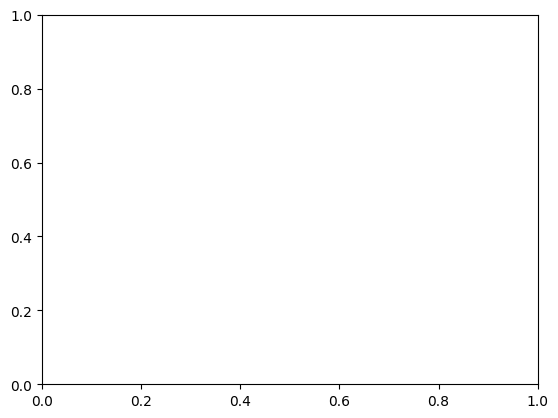

In [10]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt



# Convert 'time' column to datetime format
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')

# Create a time series object from the data
ts = pd.Series(df['close'], index=df['time'])

# Remove any NaN values
ts = ts.dropna()

# Plot the ACF
sm.graphics.tsa.plot_acf(ts, lags=50)
plt.show()

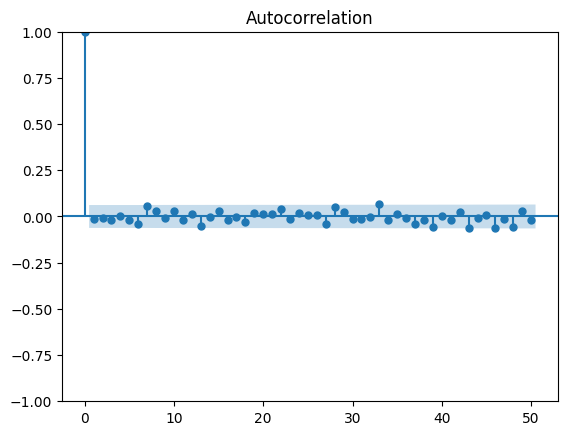

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# create a random dataset
data = np.random.rand(1000)

# create a time series object
ts = pd.Series(data)

# plot the ACF
sm.graphics.tsa.plot_acf(ts, lags=50)
plt.show()

c:\Users\nawal\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.782e-07. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\nawal\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\nawal\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to si

Iteration:      1,   Func. Count:      5,   Neg. LLF: -73359.38136064286
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -73359.38131976442
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


ValueError: 'y1' is not 1-dimensional

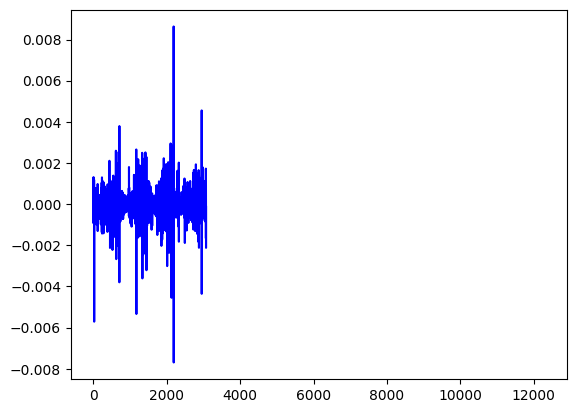

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model


# Convert 'close' column to numeric and drop missing values
df['close'] = pd.to_numeric(df['close'], errors='coerce')
df.dropna(inplace=True)

# Calculate log returns
log_returns = np.log(df['close'] / df['close'].shift(-1))

# Split the data into train and test
train = log_returns[:int(0.8*(len(log_returns)))]
test = log_returns[int(0.8*(len(log_returns))):]

# Define the model
model = arch_model(train, mean='Constant', vol='GARCH', p=1, q=1)

# Fit the model
model_fit = model.fit()

# Forecast the test set
forecast = model_fit.forecast(horizon=len(test))
yhat = forecast.mean
volatility = np.sqrt(forecast.variance.iloc[-1,:])

# Plot the actual and forecast values
plt.plot(test.values, label='Actual', color='blue')
plt.plot(yhat, label='Forecast', color='red')
plt.fill_between(yhat.index, yhat-volatility, yhat+volatility, alpha=0.1, color='gray')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('GARCH(1,1) Forecast')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from arch import arch_model


df['close'] = pd.to_numeric(df['Close'], errors='coerce')
df.dropna(inplace=True)

log_returns = np.log(df['close'] / df['close'].shift(-1))

# split the data into train and test
train = log_returns[:int(0.8*(len(log_returns)))]
test = log_returns[int(0.8*(len(log_returns))):]

# define the GARCH model
model_garch = arch_model(train, mean='Constant', vol='GARCH', p=1, q=1)

# fit the GARCH model
model_garch_fit = model_garch.fit()

# get the predicted variance using the fitted GARCH model
yhat_var = model_garch_fit.forecast(horizon=len(test))

# reshape y1 to one-dimensional array
y1 = test.to_numpy().ravel()

# plot the actual and predicted values of y1 and the predicted variance
plt.plot(y1, label='Actual', color='blue')
plt.plot(yhat_var.variance.values[-1, :], label='Predicted Variance', color='red')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('GARCH(1,1) Predicted Variance')
plt.legend()
plt.show()


KeyError: 'Close'

In [ ]:
import pandas as pd
import numpy as np
from arch import arch_model

# load data
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df.dropna(inplace=True)

# calculate log returns
log_returns = np.log(df['Close'] / df['Close'].shift())

# split the data into train and test
train = log_returns[:int(0.8 * len(log_returns))]
test = log_returns[int(0.8 * len(log_returns)):]

# define the model
model = arch_model(train, mean='Constant', vol='GARCH', p=1, q=1)

# fit the model
model_fit = model.fit()

# print the final volatility calculated using training data
final_volatility = np.sqrt(model_fit.conditional_volatility[-1])
print(f"Final volatility: {final_volatility:.4f}")


KeyError: 'Close'

In [27]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
# drop the first row
df = df.drop(df.index[0])

# Convert 'time' column to datetime format
#df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')

# calculate log returns
log_returns = np.log(df['close'] / df['close'].shift())

# Create a time series object from the data
ts = pd.Series(df['log_returns'], index=df['time'])

# Remove any NaN values
ts = ts.dropna()

# Plot the ACF
sm.graphics.tsa.plot_acf(ts, lags=50)
plt.show()


TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [20]:
from statsmodels.tsa.stattools import kpss
import pandas as pd

# load data
#df = pd.read_csv('your_file.csv', index_col='Date', parse_dates=True)

# drop missing values
df.dropna(inplace=True)

# calculate log returns
log_returns = np.log(df['close'] / df['close'].shift())

# perform KPSS test
kpss_stat, p_value, lags, critical_values = kpss(df['log_returns'])

# print results
print(f'KPSS statistic: {kpss_stat:.4f}')
print(f'p-value: {p_value:.4f}')
print(f'lags: {lags}')
print('Critical values:')
for key, value in critical_values.items():
    print(f'   {key}: {value:.4f}')

KPSS statistic: 0.0769
p-value: 0.1000
lags: 36
Critical values:
   10%: 0.3470
   5%: 0.4630
   2.5%: 0.5740
   1%: 0.7390


c:\Users\nawal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [26]:
from scipy.stats import describe

# Calculate the moments
moments = describe(df['log_returns'])

# Print the statistics for all four moments
print(f"Mean: {moments.mean}")
print(f"Standard Deviation: {np.sqrt(moments.variance)}")
print(f"Skewness: {moments.skewness}")
print(f"Kurtosis: {moments.kurtosis}")


KeyError: 'log_returns'

In [28]:
import pandas as pd
import numpy as np
from scipy.stats import describe

# Load the data
#df = pd.read_csv('stock_prices.csv', index_col='date')

# Calculate the log returns
df['log_return'] = np.log(df['close']) - np.log(df['close'].shift(-1))

# Calculate the moments
moments = describe(df['log_return'].dropna())

# Print the statistics for all four moments
print(f"Mean: {moments.mean}")
print(f"Variance: {moments.variance}")
print(f"Skewness: {moments.skewness}")
print(f"Kurtosis: {moments.kurtosis}")


TypeError: loop of ufunc does not support argument 0 of type str which has no callable log method